In [1]:
# !pip install "numpy<2.0" "shap<0.47"
# !pip install "numexpr>=2.10.2"
# !pip install xgboost==1.7.6
import shap
import pandas as pd
import seaborn as sns
import numpy as np
import math
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import (
    train_test_split, 
    RepeatedStratifiedKFold, 
    cross_val_score, 
    GridSearchCV,
    StratifiedKFold,
    RandomizedSearchCV,
    cross_val_predict)
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    f1_score, 
    classification_report, 
    make_scorer,
    average_precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    matthews_corrcoef,
    precision_recall_curve,
    roc_curve, 
    auc,
    roc_auc_score
)
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import roc_curve, auc, precision_score, recall_score
import os

In [2]:
print(os.getcwd())

/home/nbatjargal/DSC180A_FA25_A00/Majorana-Neutrino-Hunt/classification


In [3]:
path = "~/DSC180A_FA25_A00/Majorana-Neutrino-Hunt/extracted_features_csv_files/combined_csv_files/"

In [4]:
train_df = pd.read_csv(path+'combined_train_with_labels.csv.gz')
train_df

,id,energy_label,psd_label_low_avse,psd_label_high_avse,psd_label_dcr,psd_label_lq,tp0,ED,HWP,LQ80,...,tdrift50,tdrift99,tfr,peak_count,gbn,bpr,AvsE,GradAreaRatio,GradWidthMain,HFER
0,0_train_0,582.364295,False,True,True,True,957,3409.0,2120.0,-635333.796311,...,65.0,85.0,0.142357,3,1.198436,0.059642,0.519805,1.000000,76.0,0.034772
1,1_train_0,250.159995,False,True,True,True,948,3404.0,2004.0,-289756.893085,...,60.0,87.0,0.151160,3,1.381123,0.061975,0.531775,1.000000,46.0,0.037621
2,2_train_0,1212.323954,False,True,False,True,965,3411.0,2125.0,-379843.029134,...,67.0,95.0,0.142606,3,1.361857,0.050813,0.343676,1.000000,90.0,0.035552
3,3_train_0,240.878110,False,True,True,False,927,3408.0,2098.0,-252673.626844,...,90.0,116.0,0.133192,2,1.165654,0.062954,0.483144,1.000000,56.0,0.035093
4,4_train_0,285.124189,False,True,True,False,958,3406.0,2037.0,-317761.453582,...,61.0,94.0,0.145504,7,1.390918,0.055013,0.377738,1.000000,53.0,0.035971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039995,1039995_train_15,210.834626,True,True,True,True,949,3403.0,2048.0,-240759.341995,...,55.0,90.0,0.151747,6,1.008092,0.062825,0.573645,33.442724,69.0,0.035228
1039996,1039996_train_15,380.170340,True,True,True,True,949,3404.0,2045.0,-417622.302428,...,57.0,79.0,0.150305,3,1.245492,0.062706,0.564955,58.862967,71.0,0.034669
1039997,1039997_train_15,370.109563,False,True,True,True,947,3409.0,2063.0,-407730.168602,...,77.0,102.0,0.142950,2,1.149456,0.062153,0.473789,143.746154,79.0,0.034553
1039998,1039998_train_15,98.258524,True,True,True,False,921,3400.0,2001.0,-116570.568893,...,71.0,92.0,0.153135,5,1.192639,0.065264,0.572606,1.000000,42.0,0.039377


In [5]:
test_df = pd.read_csv(path+'combined_test_with_labels.csv.gz')
test_df

,id,energy_label,psd_label_low_avse,psd_label_high_avse,psd_label_dcr,psd_label_lq,tp0,ED,HWP,LQ80,...,tdrift50,tdrift99,tfr,peak_count,gbn,bpr,AvsE,GradAreaRatio,GradWidthMain,HFER
0,2395098_test_0,1167.174731,True,True,True,True,967,3407.0,2036.0,-1.300536e+06,...,55.0,76.0,0.148591,1,1.282821,0.062497,0.553581,2.257453e+02,69.0,0.034373
1,2395099_test_0,870.765543,False,True,True,False,960,3405.0,2019.0,-9.729822e+05,...,70.0,90.0,0.147334,1,1.203640,0.063886,0.573090,2.120524e+12,88.0,0.034307
2,2395100_test_0,582.980526,False,True,True,True,960,3412.0,2107.0,-6.390870e+05,...,76.0,100.0,0.139090,2,1.189320,0.057715,0.443685,1.784824e+02,84.0,0.034885
3,2395101_test_0,238.918902,True,True,True,True,930,3408.0,2053.0,-2.760460e+05,...,88.0,110.0,0.138597,2,1.226275,0.067184,0.583046,1.000000e+00,53.0,0.035474
4,2395102_test_0,214.491195,False,True,True,True,924,3406.0,1939.0,-7.611188e+04,...,83.0,135.0,0.149185,13,1.203153,0.055602,0.403248,1.000000e+00,46.0,0.051582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389995,2785093_test_5,238.472881,False,True,True,False,940,3406.0,2081.0,-2.667054e+05,...,69.0,111.0,0.144375,2,1.198436,0.062338,0.518905,1.000000e+00,73.0,0.034997
389996,2785094_test_5,452.840234,True,True,True,True,952,3406.0,2058.0,-5.194853e+05,...,59.0,83.0,0.148058,3,2.268535,0.064586,0.590262,5.597816e+01,54.0,0.035930
389997,2785095_test_5,344.740556,True,True,True,True,948,3406.0,2036.0,-3.684673e+05,...,80.0,125.0,0.140774,3,1.217066,0.062375,0.536752,1.000000e+00,82.0,0.034713
389998,2785096_test_5,163.807547,True,True,True,True,925,3406.0,2067.0,-1.903450e+05,...,94.0,116.0,0.140754,2,0.975055,0.066704,0.577498,1.000000e+00,41.0,0.036159


In [6]:
classification_label_cols = [
    "psd_label_lq",
    "psd_label_high_avse",
    "psd_label_low_avse",
    "psd_label_dcr"
]

non_label_cols = ["id", "energy_label"]

feature_cols = [col for col in train_df.columns if col not in classification_label_cols+non_label_cols]
print("Number of feataures:",len(feature_cols))
feature_cols

Number of feataures: 27


['tp0',
 'ED',
 'HWP',
 'LQ80',
 'PPR',
 'SCA',
 'ND80',
 'current_skewness',
 'tail_slope_no_pz',
 'spectral_centroid_power',
 'current_kurtosis',
 'tail_slope',
 'total_power',
 'time_to_main_peak',
 'time_to_peak',
 'current_width',
 'tdrift10',
 'tdrift50',
 'tdrift99',
 'tfr',
 'peak_count',
 'gbn',
 'bpr',
 'AvsE',
 'GradAreaRatio',
 'GradWidthMain',
 'HFER']

In [11]:
# Filter rows where ALL of these columns are True
# .all(axis=1) checks if every column in the list is True for that row
matching_rows = train_df[train_df[classification_label_cols].all(axis=1)]
matching_rows

,id,energy_label,psd_label_low_avse,psd_label_high_avse,psd_label_dcr,psd_label_lq,tp0,ED,HWP,LQ80,...,tdrift50,tdrift99,tfr,peak_count,gbn,bpr,AvsE,GradAreaRatio,GradWidthMain,HFER
5,5_train_0,202.118818,True,True,True,True,938,3401.0,2016.0,-2.238298e+05,...,62.0,86.0,0.148161,2,1.333229,0.066141,0.588104,2.991743e+01,39.0,0.048042
6,6_train_0,855.765685,True,True,True,True,953,3413.0,2110.0,-9.533368e+05,...,88.0,106.0,0.136972,1,1.463301,0.061205,0.528196,1.570316e+02,93.0,0.034815
8,8_train_0,1212.688940,True,True,True,True,961,3412.0,2089.0,-1.336303e+06,...,82.0,105.0,0.140185,1,1.217066,0.065910,0.591604,1.603469e+02,92.0,0.034293
11,11_train_0,2334.785962,True,True,True,True,961,3412.0,2061.0,-2.494320e+06,...,92.0,117.0,0.139700,1,1.488288,0.062823,0.566847,5.637905e+12,109.0,0.034266
14,14_train_0,2130.987393,True,True,True,True,980,3401.0,2057.0,-2.373392e+06,...,21.0,43.0,0.157380,1,2.648069,0.072427,0.639669,5.235714e+12,48.0,0.033637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039985,1039985_train_15,238.270546,True,True,True,True,966,3401.0,2024.0,-2.676853e+05,...,26.0,77.0,0.164503,2,1.653406,0.070927,0.611792,3.050746e+01,42.0,0.034336
1039986,1039986_train_15,230.961021,True,True,True,True,929,3408.0,2032.0,-2.581743e+05,...,94.0,116.0,0.138498,1,1.165428,0.069788,0.606824,8.871756e+01,64.0,0.034692
1039990,1039990_train_15,299.894902,True,True,True,True,932,3407.0,2021.0,-3.529948e+05,...,84.0,119.0,0.138221,4,1.135231,0.066935,0.584033,1.000000e+00,52.0,0.034463
1039995,1039995_train_15,210.834626,True,True,True,True,949,3403.0,2048.0,-2.407593e+05,...,55.0,90.0,0.151747,6,1.008092,0.062825,0.573645,3.344272e+01,69.0,0.035228


# MODEL TRAINING - psd_label_high_avse

In [7]:
# DATA PREP
X_train = train_df[feature_cols]
y_train = train_df["psd_label_high_avse"]

X_test = test_df[feature_cols]
y_test = test_df["psd_label_high_avse"]
test_ids = test_df["id"]

### Test Dataset

In [13]:
pd.concat([y_test.value_counts(), 
           y_test.value_counts(normalize=True)], axis=1)

,count,proportion
psd_label_high_avse,,
True,386840,0.991897
False,3160,0.008103


In [14]:
X_test.isna().sum().sort_values(ascending=False)

tp0                        0
time_to_peak               0
GradWidthMain              0
GradAreaRatio              0
AvsE                       0
bpr                        0
gbn                        0
peak_count                 0
tfr                        0
tdrift99                   0
tdrift50                   0
tdrift10                   0
current_width              0
time_to_main_peak          0
ED                         0
total_power                0
tail_slope                 0
current_kurtosis           0
spectral_centroid_power    0
tail_slope_no_pz           0
current_skewness           0
ND80                       0
SCA                        0
PPR                        0
LQ80                       0
HWP                        0
HFER                       0
dtype: int64

### Train Dataset

In [15]:
pd.concat([y_train.value_counts(), 
           y_train.value_counts(normalize=True)], axis=1)

,count,proportion
psd_label_high_avse,,
True,1031559,0.991884
False,8441,0.008116


In [16]:
X_train.isna().sum().sort_values(ascending=False)

tdrift99                   5
tdrift50                   5
tdrift10                   5
tp0                        0
time_to_peak               0
GradWidthMain              0
GradAreaRatio              0
AvsE                       0
bpr                        0
gbn                        0
peak_count                 0
tfr                        0
current_width              0
time_to_main_peak          0
ED                         0
total_power                0
tail_slope                 0
current_kurtosis           0
spectral_centroid_power    0
tail_slope_no_pz           0
current_skewness           0
ND80                       0
SCA                        0
PPR                        0
LQ80                       0
HWP                        0
HFER                       0
dtype: int64

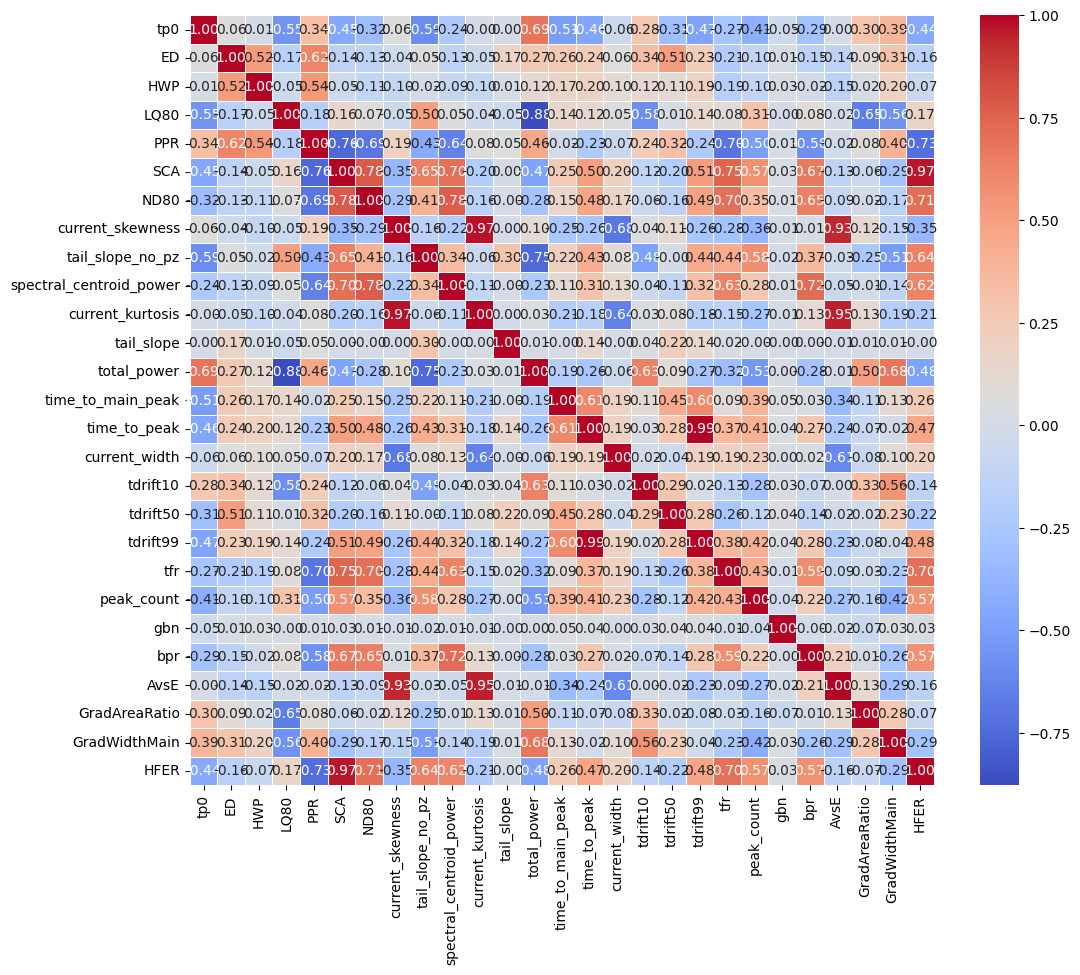

In [18]:
correlation_matrix = pd.DataFrame(X_train).corr()
plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix, annot=True,cmap='coolwarm',fmt=".2f", linewidths=.5)

plt.savefig('high_avse_plots/correlation_heatmap.png', dpi=300, bbox_inches='tight')

plt.show()

In [8]:
# output folders
base_dir = "high_avse_plots"
sub_dir = "feat_dist"
save_dir = os.path.join(base_dir, sub_dir)
os.makedirs(save_dir, exist_ok=True)

Saving per-feature plots to: high_avse_plots/feat_dist
Displaying 3 grids (3 per row)...


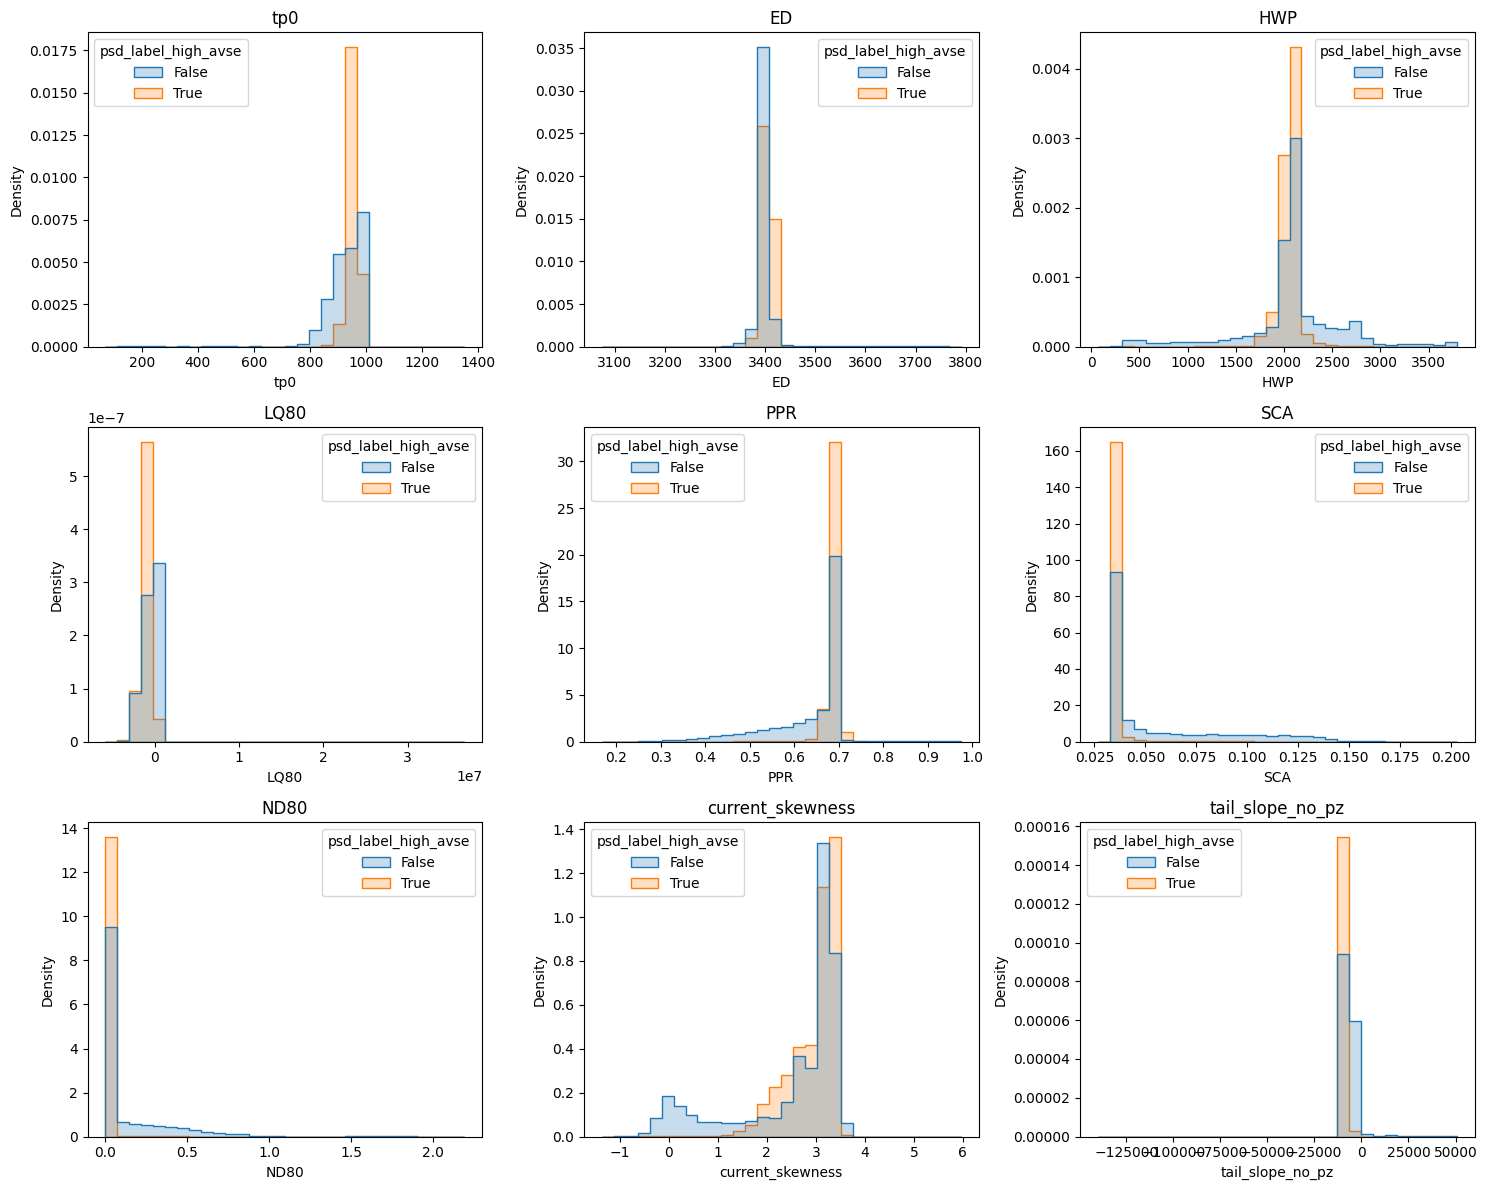

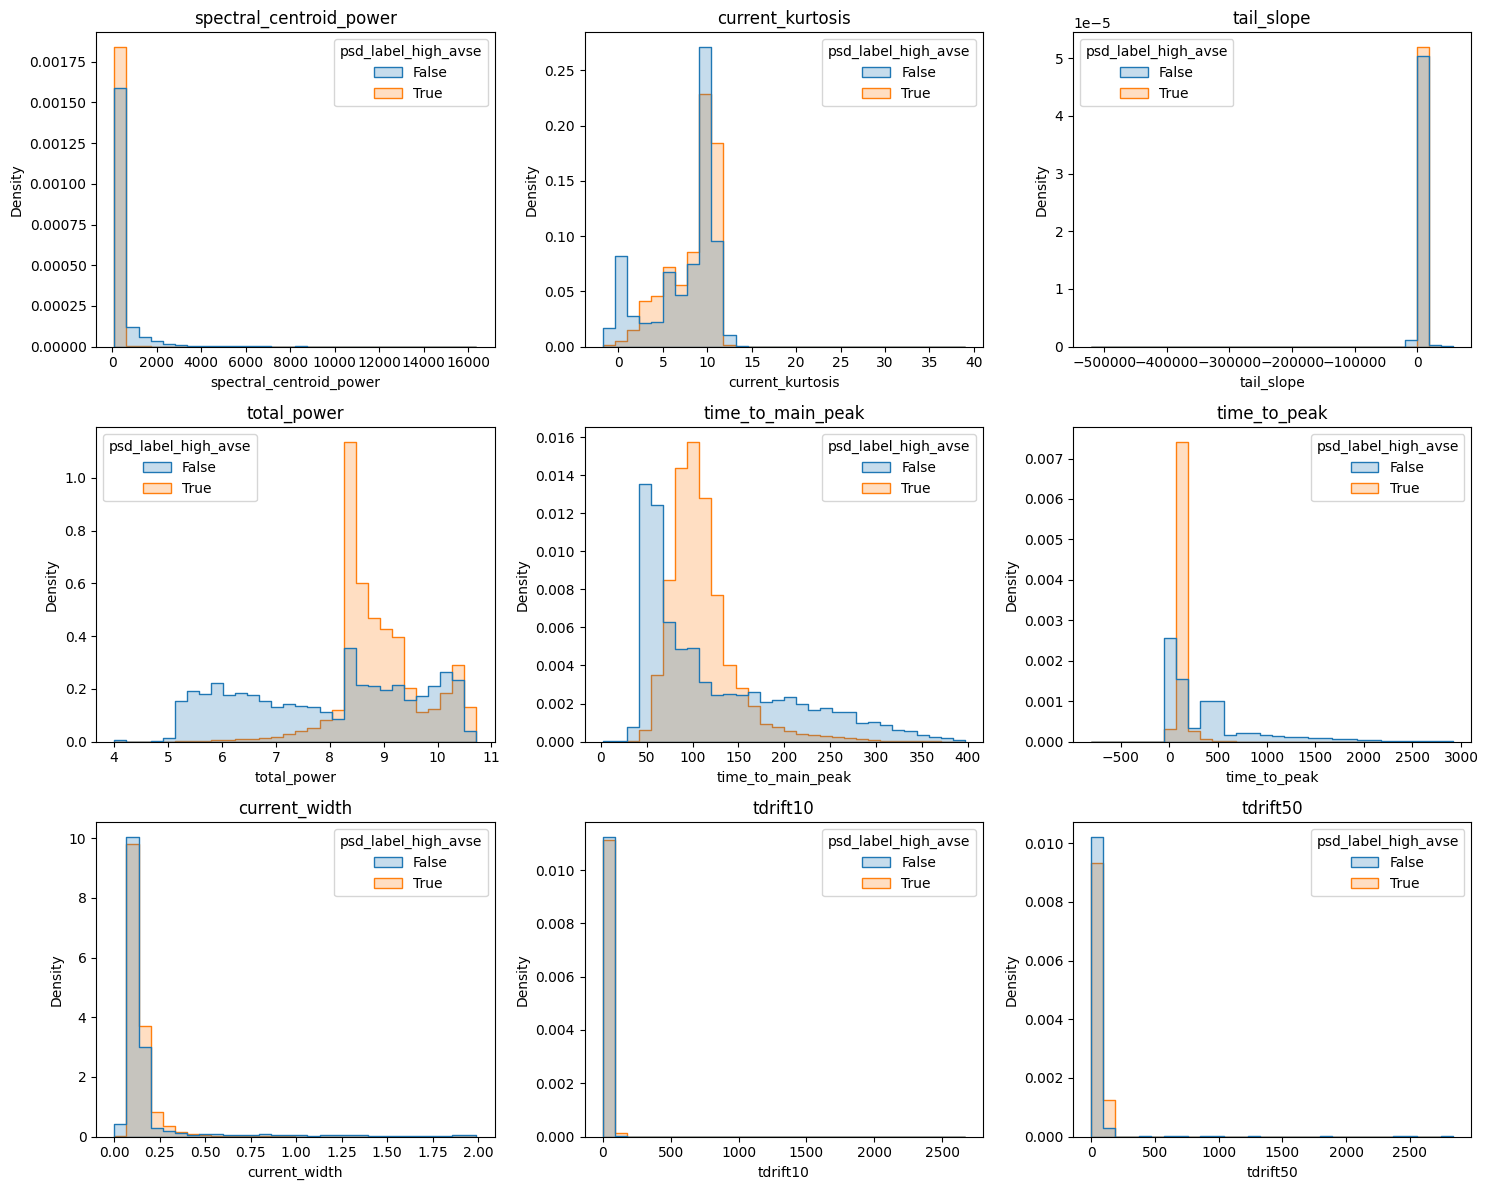

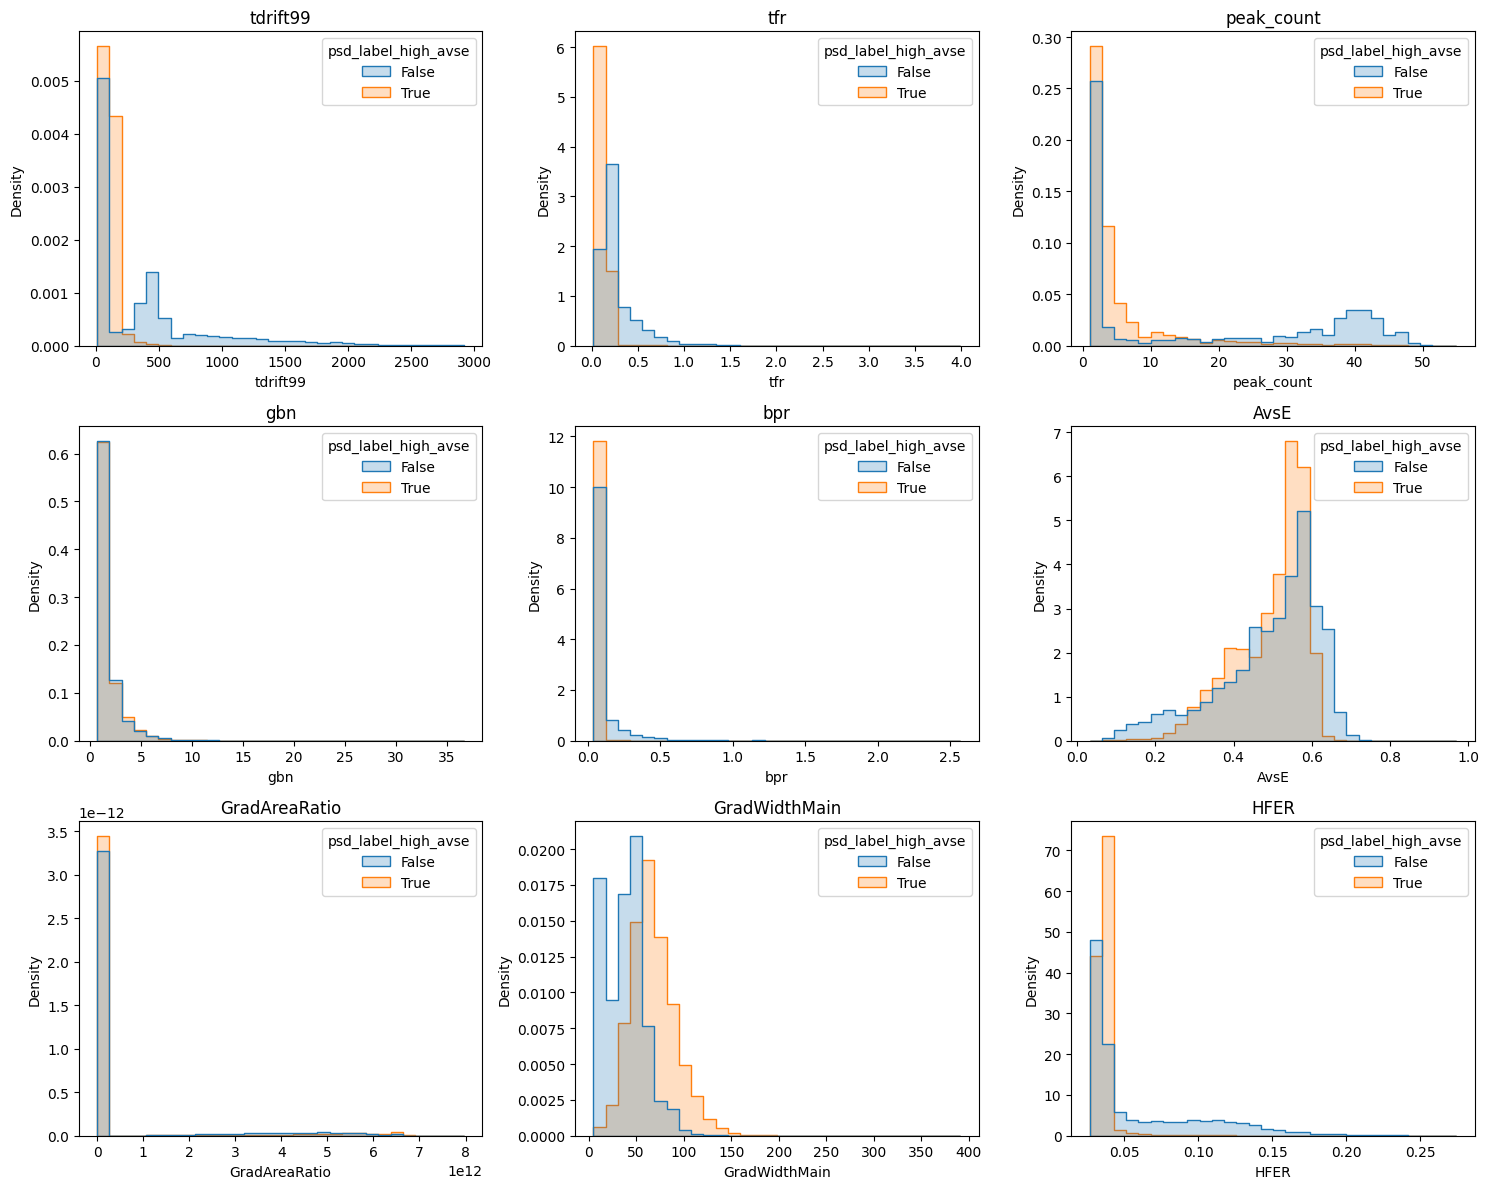

In [22]:
features_per_batch = 9   # 3x3 grid
n_cols = 3
total_features = len(feature_cols)
num_batches = math.ceil(total_features / features_per_batch)

print(f"Saving per-feature plots to: {save_dir}")
print(f"Displaying {num_batches} grids (3 per row)...")

for b in range(num_batches):
    start = b * features_per_batch
    end = min((b + 1) * features_per_batch, total_features)
    batch_features = feature_cols[start:end]

    n_rows = math.ceil(len(batch_features) / n_cols)
    fig_grid, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
    axes = axes.flatten() if (n_rows * n_cols) > 1 else [axes]

    for i, feature in enumerate(batch_features):
        # --- 1) display in grid ---
        sns.histplot(
            data=train_df,
            x=feature,
            hue="psd_label_high_avse",
            element="step",
            stat="density",
            common_norm=False,
            bins=30,
            ax=axes[i],
        )
        axes[i].set_title(feature)

        # --- 2) save a single-feature figure ---
        fig_single, ax_single = plt.subplots(figsize=(7, 4))
        sns.histplot(
            data=train_df,
            x=feature,
            hue="psd_label_high_avse",
            element="step",
            stat="density",
            common_norm=False,
            bins=30,
            ax=ax_single,
        )
        ax_single.set_title(feature)
        fig_single.tight_layout()

        fpath = os.path.join(save_dir, f"feat_dist_{feature}.png")
        fig_single.savefig(fpath, dpi=300, bbox_inches="tight")
        plt.close(fig_single)  # don't display singles

    # hide empty axes
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    fig_grid.tight_layout()
    plt.show()
    plt.close(fig_grid)

### DEFINE CUSTOM SCORERS (For Tuning)

In [9]:
# We wrap these in make_scorer so RandomizedSearchCV can track counts
def tn_score(y_true, y_pred): return confusion_matrix(y_true, y_pred).ravel()[0]
def fp_score(y_true, y_pred): return confusion_matrix(y_true, y_pred).ravel()[1]
def fn_score(y_true, y_pred): return confusion_matrix(y_true, y_pred).ravel()[2]
def tp_score(y_true, y_pred): return confusion_matrix(y_true, y_pred).ravel()[3]

scoring_metrics = {
    'MCC': make_scorer(matthews_corrcoef),
    'AUC_PR': make_scorer(average_precision_score, response_method="predict_proba"),
    'AUC_ROC': make_scorer(roc_auc_score, response_method="predict_proba"),
    'Class0_F1': make_scorer(f1_score, pos_label=0), 
    'Class1_F1': make_scorer(f1_score, pos_label=1),
    'TN': make_scorer(tn_score),
    'FP': make_scorer(fp_score),
    'FN': make_scorer(fn_score),
    'TP': make_scorer(tp_score)
}

# columns we want to keep
cols_to_show = [
    'params',
    'mean_test_MCC', 
    'mean_test_AUC_PR', 
    'mean_test_AUC_ROC',
    'mean_test_Class0_F1',
    'mean_test_Class1_F1',
    'mean_test_TN', 'mean_test_FP', # Class 0 Performance
    'mean_test_TP', 'mean_test_FN', # Class 1 Performance
]

In [10]:
def tune_thresholds(
    model,
    X_train,
    y_train,
    cv=5,
    thresholds=None,
    base_dir=base_dir,
    run_name="high_avse",
    save_plot=True,
    show_plot=True,
    save_csv=True,
):
    """
    Finds the optimal probability threshold using Cross-Validation on the Training set.

    Adds:
      - Plot: MCC vs Threshold (saved to base_dir if save_plot=True)
      - CSV: Full tuning progress table (saved to base_dir if save_csv=True)

    Args:
        model: The classifier (estimator) to evaluate.
        X_train: Training features.
        y_train: Training labels.
        cv: Number of cross-validation folds (default 5).
        thresholds: List/array of thresholds to test. If None, uses default range.
        base_dir: Folder to save plot PNG + CSV into.
        run_name: Optional string to include in plot title/filename (e.g., label name).
        save_plot: If True, saves a PNG into base_dir.
        show_plot: If True, displays the plot.
        save_csv: If True, saves the full per-threshold results to CSV into base_dir.

    Returns:
        pd.DataFrame: Sorted results by MCC (best threshold first).
    """

    print(f"Generating Cross-Validated Probabilities (CV={cv})...")

    # 1. Generate "Clean" Probabilities via Cross-Validation
    if hasattr(model, "predict_proba"):
        y_probas_cv = cross_val_predict(
            model, X_train, y_train, cv=cv, method="predict_proba"
        )[:, 1]
    else:
        raise ValueError("Model must support predict_proba")

    # 2. Define Thresholds
    if thresholds is None:
        thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]
    thresholds = np.array(thresholds, dtype=float)

    # 3. Calculate Constant Metrics (CV-based)
    cv_auc_pr = average_precision_score(y_train, y_probas_cv)
    cv_auc_roc = roc_auc_score(y_train, y_probas_cv)

    results = []

    # 4. Loop through thresholds
    for thresh in thresholds:
        y_pred = (y_probas_cv >= thresh).astype(int)

        tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()

        results.append(
            {
                "Threshold": float(thresh),
                "MCC": matthews_corrcoef(y_train, y_pred),
                "Precision": precision_score(y_train, y_pred, zero_division=0),
                "Recall": recall_score(y_train, y_pred, zero_division=0),
                "True_F1": f1_score(y_train, y_pred, pos_label=1, zero_division=0),
                "False_F1": f1_score(y_train, y_pred, pos_label=0, zero_division=0),
                "TN": tn,
                "FP": fp,
                "FN": fn,
                "TP": tp,
                "CV_AUC_PR": cv_auc_pr,
                "CV_AUC_ROC": cv_auc_roc,
            }
        )

    df_results = pd.DataFrame(results)
    df_sorted = df_results.sort_values(by="MCC", ascending=False).reset_index(drop=True)

    # -----------------------------
    # Naming helpers (plot + csv)
    # -----------------------------
    model_name = model.__class__.__name__
    safe_run = f"_{run_name}" if run_name else ""

    if save_plot or save_csv:
        os.makedirs(base_dir, exist_ok=True)

    # -----------------------------
    # Save CSV of tuning progress
    # -----------------------------
    if save_csv:
        # Save in increasing threshold order so it's easy to read as "progress"
        df_progress = df_results.sort_values("Threshold").reset_index(drop=True)

        csv_name = f"threshold_tuning_progress_{model_name}{safe_run}_cv{cv}.csv"
        csv_path = os.path.join(base_dir, csv_name)
        df_progress.to_csv(csv_path, index=False)
        print(f"Saved threshold tuning progress CSV to: {csv_path}")

    # -----------------------------
    # Plot MCC vs Threshold + Save
    # -----------------------------
    if save_plot or show_plot:
        df_plot = df_results.sort_values("Threshold").reset_index(drop=True)

        best_row = df_sorted.iloc[0]
        best_thresh = best_row["Threshold"]
        best_mcc = best_row["MCC"]

        plot_title = (
            f"Threshold Tuning (CV={cv}) — MCC vs Threshold\n"
            f"Model: {model_name}{' | ' + run_name if run_name else ''} | "
            f"Best thr={best_thresh:.3f}, MCC={best_mcc:.3f}"
        )

        fig = plt.figure(figsize=(8, 5))
        plt.plot(df_plot["Threshold"], df_plot["MCC"], marker="o")
        plt.axvline(best_thresh, linestyle="--")
        plt.scatter([best_thresh], [best_mcc], zorder=5)

        plt.title(plot_title)
        plt.xlabel("Threshold")
        plt.ylabel("MCC")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()

        if save_plot:
            png_name = f"threshold_tuning_mcc_{model_name}{safe_run}_cv{cv}.png"
            png_path = os.path.join(base_dir, png_name)
            plt.savefig(png_path, dpi=200, bbox_inches="tight")
            print(f"Saved threshold MCC plot to: {png_path}")

        if show_plot:
            plt.show()
        else:
            plt.close(fig)

    return df_sorted

In [11]:
def evaluate_model_with_threshold(
    model,
    X_test,
    y_test,
    threshold=0.5,
    model_name="",
    base_dir=base_dir,
    run_name="high_avse",
    save_plots=True,
    show_plots=True,
    save_metrics_csv=True,        
):
    """
    Final evaluation on the Test set using a fixed decision threshold.

    Saves (to base_dir):
      - Confusion Matrix PNG
      - ROC Curve PNG
      - Precision–Recall Curve PNG
      - Metrics CSV (1 row summary)
      - Predictions CSV (y_true, y_prob, y_pred + optional ID column)

    Args:
        model: Trained classifier (must have predict_proba).
        X_test: Test features.
        y_test: True test labels.
        threshold (float): Decision threshold.
        model_name (str): Used for plot titles and filenames.
        base_dir (str): Output folder.
        run_name (str|None): Optional label/task name to include in filenames.
        save_plots (bool): Save plots as PNGs.
        show_plots (bool): Show plots inline.
        save_metrics_csv (bool): Save summary metrics CSV.
    Returns:
        dict: {"metrics": metrics_row, "saved_files": {...}}
    """
    if not hasattr(model, "predict_proba"):
        raise ValueError("Model must support predict_proba")

    print(f"\n{'='*40}")
    print(f" FINAL EVALUATION: {model_name} (Threshold = {threshold})")
    print(f"{'='*40}")

    # 1) Probabilities + thresholded predictions
    y_probs = model.predict_proba(X_test)[:, 1]
    y_pred = (y_probs >= threshold).astype(int)

    # 2) Print report
    print(classification_report(y_test, y_pred, digits=4))

    # 3) Metrics
    auc_roc = roc_auc_score(y_test, y_probs)
    auc_pr = average_precision_score(y_test, y_probs)
    mcc = matthews_corrcoef(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"AUC-ROC Score: {auc_roc:.6f}")
    print(f"AUC-PR Score:  {auc_pr:.6f}")
    print(f"MCC Score:     {mcc:.6f}")

    # 4) Naming + output dir
    os.makedirs(base_dir, exist_ok=True)
    safe_model = "".join(c if c.isalnum() or c in "-_" else "_" for c in model_name)
    safe_run = f"_{run_name}" if run_name else ""

    saved_files = {}

    # -------------------------
    # Confusion Matrix plot
    # -------------------------
    fig_cm, ax_cm = plt.subplots(figsize=(6, 5))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["False", "True"])
    disp.plot(cmap="Blues", ax=ax_cm)
    ax_cm.set_title(f"{model_name} Confusion Matrix\n(Threshold = {threshold})")
    plt.tight_layout()

    if save_plots:
        cm_png = f"final_eval_cm_{safe_model}{safe_run}.png"
        cm_path = os.path.join(base_dir, cm_png)
        plt.savefig(cm_path, dpi=200, bbox_inches="tight")
        saved_files["confusion_matrix_png"] = cm_path
        print(f"Saved confusion matrix plot to: {cm_path}")

    if show_plots:
        plt.show()
    else:
        plt.close(fig_cm)

    # -------------------------
    # ROC Curve plot
    # -------------------------
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    fig_roc = plt.figure(figsize=(6.5, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc_roc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
    plt.title(f"{model_name} ROC Curve\n(Threshold = {threshold})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    if save_plots:
        roc_png = f"final_eval_roc_{safe_model}{safe_run}.png"
        roc_path = os.path.join(base_dir, roc_png)
        plt.savefig(roc_path, dpi=200, bbox_inches="tight")
        saved_files["roc_curve_png"] = roc_path
        print(f"Saved ROC curve plot to: {roc_path}")

    if show_plots:
        plt.show()
    else:
        plt.close(fig_roc)

    # -------------------------
    # Precision–Recall plot
    # -------------------------
    precision, recall, _ = precision_recall_curve(y_test, y_probs)
    fig_pr = plt.figure(figsize=(6.5, 5))
    plt.plot(recall, precision, label=f"AUC-PR = {auc_pr:.4f}")
    plt.title(f"{model_name} Precision–Recall Curve\n(Threshold = {threshold})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    if save_plots:
        pr_png = f"final_eval_pr_{safe_model}{safe_run}.png"
        pr_path = os.path.join(base_dir, pr_png)
        plt.savefig(pr_path, dpi=200, bbox_inches="tight")
        saved_files["pr_curve_png"] = pr_path
        print(f"Saved PR curve plot to: {pr_path}")

    if show_plots:
        plt.show()
    else:
        plt.close(fig_pr)

    # -------------------------
    # Metrics CSV (1 row)
    # -------------------------
    report = classification_report(y_test, y_pred, digits=4, output_dict=True)
    metrics_row = {
        "threshold": float(threshold),
        "auc_roc": float(auc_roc),
        "auc_pr": float(auc_pr),
        "mcc": float(mcc),
        "tn": int(cm[0, 0]),
        "fp": int(cm[0, 1]),
        "fn": int(cm[1, 0]),
        "tp": int(cm[1, 1]),
        "precision_pos": float(report.get("True", {}).get("precision", np.nan)),
        "recall_pos": float(report.get("True", {}).get("recall", np.nan)),
        "f1_pos": float(report.get("True", {}).get("f1-score", np.nan)),
        "precision_neg": float(report.get("False", {}).get("precision", np.nan)),
        "recall_neg": float(report.get("False", {}).get("recall", np.nan)),
        "f1_neg": float(report.get("False", {}).get("f1-score", np.nan)),
        "accuracy": float(report.get("accuracy", np.nan)),
    }

    if save_metrics_csv:    
        # column name for this model in the transposed table
        model_col = f"{model_name}{safe_run}" if safe_run else model_name
    
        # transpose: metrics become rows, this model becomes one column
        df_metrics_t = pd.DataFrame([metrics_row]).T.reset_index()
        df_metrics_t.columns = ["metric", model_col]
    
        metrics_path = os.path.join("high_avse_plots", "final_eval_metrics_by_model_columns.csv")
    
        if os.path.exists(metrics_path):
            df_existing = pd.read_csv(metrics_path)
    
            # remove old column with same model name if rerunning (optional but useful)
            if model_col in df_existing.columns:
                df_existing = df_existing.drop(columns=[model_col])
    
            # merge so new model becomes a new column
            df_out = df_existing.merge(df_metrics_t, on="metric", how="outer")
        else:
            df_out = df_metrics_t
    
        df_out.to_csv(metrics_path, index=False)
    
        saved_files["metrics_csv"] = metrics_path
        print(f"Saved/updated transposed metrics CSV to: {metrics_path}")
    return df_metrics_t

In [12]:
# LR feature importance (coefficients)
def save_feature_importance(
    model_or_pipeline,
    base_dir,
    feature_cols=feature_cols,
    run_name="high_avse",
    model_name="logreg",
    save_csv=True,
):
    """
    For LogisticRegression (or any linear model with coef_):
    Saves Feature | Coefficient | Importance (= abs(coef))
    Works if you pass a Pipeline (it will grab the last step).
    """
    # Extract Coefficients and Feature Names
    coef_vec = pipe_baseline.named_steps['lr'].coef_[0]

    df = pd.DataFrame({
        "Feature": list(feature_cols),
        "Coefficient": coef_vec,
        "Importance": np.abs(coef_vec),
    }).sort_values("Importance", ascending=False).reset_index(drop=True)

    os.makedirs(base_dir, exist_ok=True)
    safe_run = f"_{run_name}" if run_name else ""

    path = None
    if save_csv:
        filename = f"feat_importance_{model_name}{safe_run}.csv"
        path = os.path.join(base_dir, filename)
        df.to_csv(path, index=False)
        print(f"Saved LR feature importance CSV to: {path}")

    return df, path

In [13]:
def shap_summary_plot_save(
    tree_model, 
    X_test, 
    base_dir, 
    model_name
):
    filename = f"shap_summary_{model_name}_high_avse.png"
    os.makedirs(base_dir, exist_ok=True)

    explainer = shap.TreeExplainer(tree_model)
    shap_values = explainer.shap_values(X_test)

    # Binary classifier handling (older SHAP)
    if isinstance(shap_values, list):
        shap_values = shap_values[1]

    shap_values = np.asarray(shap_values)

    # If SHAP returns (n_samples, n_features, n_classes), pick positive class
    if shap_values.ndim == 3 and shap_values.shape[-1] == 2:
        shap_values = shap_values[:, :, 1]

    # Must be regular SHAP values now: (n_samples, n_features)
    print("SHAP shape:", shap_values.shape)  # should be (N, n_features)

    plt.figure(figsize=(8, 5))
    shap.summary_plot(shap_values, X_test, show=False)   # normal feature-importance beeswarm

    out_path = os.path.join(base_dir, filename)
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.show()
    print("Saved:", out_path)

## Baseline Logistic Regression

In [29]:
# Baseline performance
pipe_baseline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),  
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        solver="lbfgs"
    ))
])

In [30]:
# Train
pipe_baseline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('imputer', ...), ('scaler', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"missing_values missing_values: int, float, str, np.nan, None or pandas.NA, default=np.nanThe placeholder for the missing values. All occurrences of`missing_values` will be imputed. For pandas' dataframes withnullable integer dtypes with missing values, `missing_values`can be set to either `np.nan` or `pd.NA`.",nan
,"strategy strategy: str or Callable, default='mean'The imputation strategy.- If ""mean"", then replace missing values using the mean along each column. Can only be used with numeric data.- If ""median"", then replace missing values using the median along each column. Can only be used with numeric data.- If ""most_frequent"", then replace missing using the most frequent value along each column. Can be used with strings or numeric data. If there is more than one such value, only the smallest is returned.- If ""constant"", then replace missing values with fill_value. Can be used with strings or numeric data.- If an instance of Callable, then replace missing values using the scalar statistic returned by running the callable over a dense 1d array containing non-missing values of each column... versionadded:: 0.20 strategy=""constant"" for fixed value imputation... versionadded:: 1.5 strategy=callable for custom value imputation.",'median'
,"fill_value fill_value: str or numerical value, default=NoneWhen strategy == ""constant"", `fill_value` is used to replace alloccurrences of missing_values. For string or object data types,`fill_value` must be a string.If `None`, `fill_value` will be 0 when imputing numericaldata and ""missing_value"" for strings or object data types.",None
,"copy copy: bool, default=TrueIf True, a copy of X will be created. If False, imputation willbe done in-place whenever possible. Note that, in the following cases,a new copy will always be made, even if `copy=False`:- If `X` is not an array of floating values;- If `X` is encoded as a CSR matrix;- If `add_indicator=True`.",True
,"add_indicator add_indicator: bool, default=FalseIf True, a :class:`MissingIndicator` transform will stack onto outputof the imputer's transform. This allows a predictive estimatorto account for missingness despite imputation. I


 FINAL EVALUATION: baseline_lr (Threshold = 0.5)
              precision    recall  f1-score   support

       False     0.0846    0.8725    0.1542      3160
        True     0.9989    0.9229    0.9594    386840

    accuracy                         0.9225    390000
   macro avg     0.5417    0.8977    0.5568    390000
weighted avg     0.9915    0.9225    0.9528    390000

AUC-ROC Score: 0.958572
AUC-PR Score:  0.999538
MCC Score:     0.257630
Saved confusion matrix plot to: high_avse_plots/baseline/final_eval_cm_baseline_lr_high_avse.png


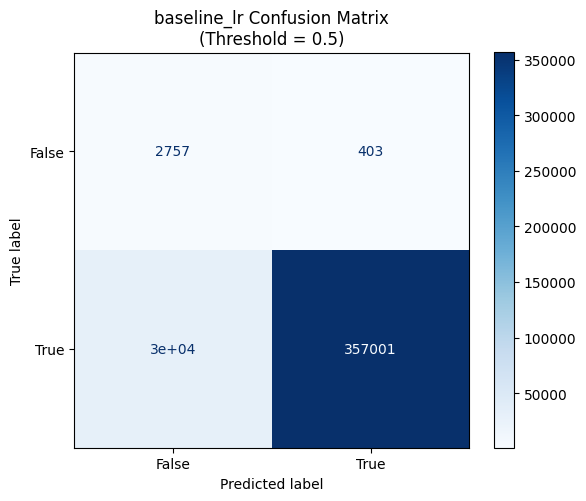

Saved ROC curve plot to: high_avse_plots/baseline/final_eval_roc_baseline_lr_high_avse.png


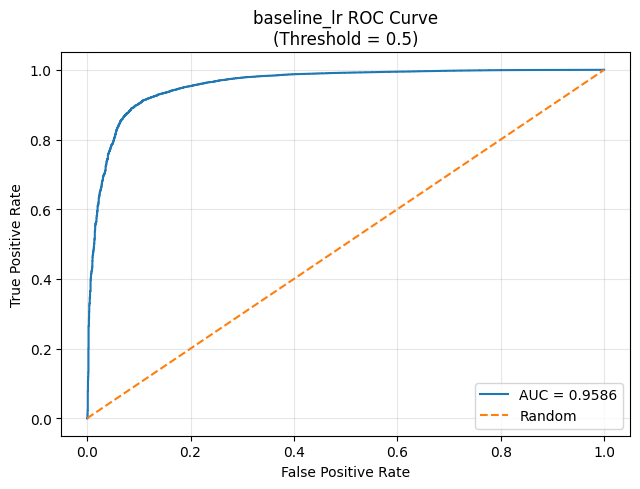

Saved PR curve plot to: high_avse_plots/baseline/final_eval_pr_baseline_lr_high_avse.png


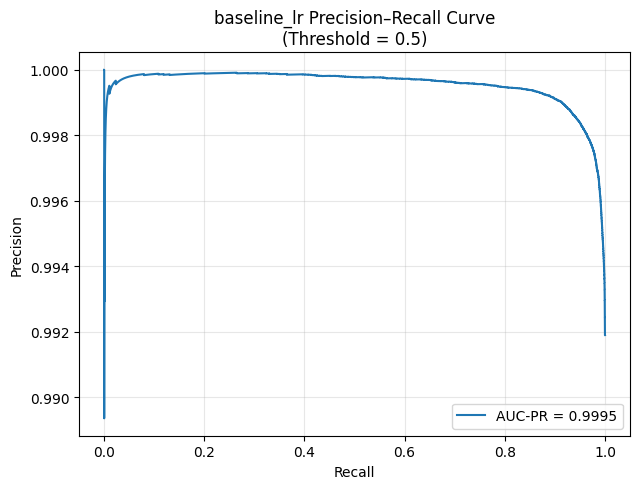

Saved/updated transposed metrics CSV to: high_avse_plots/final_eval_metrics_by_model_columns.csv


,metric,baseline_lr_high_avse
0,threshold,0.500000
1,auc_roc,0.958572
2,auc_pr,0.999538
3,mcc,0.257630
4,tn,2757.000000
5,fp,403.000000
6,fn,29839.000000
7,tp,357001.000000
8,precision_pos,0.998872
9,recall_pos,0.922865


In [58]:
evaluate_model_with_threshold(
    pipe_baseline,
    X_test,
    y_test,
    model_name="baseline_lr", 
    base_dir=base_dir+"/baseline"
)

In [50]:
save_lr_feature_importance(
    pipe_baseline,
    feature_cols=feature_cols,
    base_dir=base_dir+"/baseline",
    run_name="high_avse",
    model_name="baseline",
    save_csv=True,
)

Saved LR feature importance CSV to: high_avse_plots/baseline/feature_importance_lr_baseline_high_avse.csv


(                    Feature  Coefficient  Importance
 0          current_kurtosis     3.073010    3.073010
 1                      AvsE    -3.038263    3.038263
 2               total_power    -3.025100    3.025100
 3              time_to_peak    -2.309842    2.309842
 4          tail_slope_no_pz    -1.637403    1.637403
 5                  tdrift50     1.165955    1.165955
 6                      LQ80    -1.151986    1.151986
 7                       SCA     1.022350    1.022350
 8             GradWidthMain     1.016693    1.016693
 9                        ED    -0.699620    0.699620
 10                     HFER    -0.634220    0.634220
 11         current_skewness    -0.496610    0.496610
 12        time_to_main_peak     0.432534    0.432534
 13                      tfr    -0.394100    0.394100
 14                 tdrift99     0.360275    0.360275
 15                      PPR     0.281850    0.281850
 16                 tdrift10     0.270808    0.270808
 17                      tp0

### Optimizing Logistic Regression (hyperparamter tunning)

In [46]:
# tune the 'lr' (Logistic Regression) part of the pipe
lr_param_grid = {
    'lr__C': [0.01, 0.1, 1, 10, 100],
    'lr__class_weight': [
        'balanced',
        {0:2, 1:1},
        {0:1, 1:3},
        {0:1, 1:5},   # Mild imbalance
        {0:1, 1:10},  # Moderate
        None          # Baseline (equal weight)
    ]
}

# Use Standard Stratified K-Fold for speed during the search
lr_grid = GridSearchCV(
    estimator=pipe_baseline,        
    param_grid=lr_param_grid, 
    cv=StratifiedKFold(n_splits=5), 
    scoring=scoring_metrics,
    refit='MCC',
    n_jobs=-1,
    verbose=1
)

print("Tuning hyperparameters for Logistic Regression...")
lr_grid.fit(X_train, y_train) # runs the internal CV loops

Tuning hyperparameters for Logistic Regression...
Fitting 5 folds for each of 30 candidates, totalling 150 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step..._iter=2000))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'lr__C': [0.01, 0.1, ...], 'lr__class_weight': ['balanced', {0: 2, 1: 1}, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.","{'AUC_PR': make_scorer(a...redict_proba'), 'AUC_ROC': make_scorer(r...redict_proba'), 'Class0_F1': make_scorer(f..., pos_label=0), 'Class1_F1': make_scorer(f..., pos_label=1), ...}"
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",'MCC'
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold

In [47]:
# RESULTS VISUALIZATION
# Get the best model
lr_best_model = lr_grid.best_estimator_
print(f"Best Params found: {lr_grid.best_params_}")

# Convert the results dictionary to a DataFrame
cv_results_lr = lr_grid.cv_results_
results_df_lr = pd.DataFrame(cv_results_lr)

# Show full param dict
pd.set_option('display.max_colwidth', None)

# sorted by best performance
clean_results = results_df_lr.sort_values(by='mean_test_MCC', ascending=False)[cols_to_show]
clean_results

Best Params found: {'lr__C': 1, 'lr__class_weight': {0: 2, 1: 1}}


,params,mean_test_MCC,mean_test_AUC_PR,mean_test_AUC_ROC,mean_test_Class0_F1,mean_test_Class1_F1,mean_test_TN,mean_test_FP,mean_test_TP,mean_test_FN
13,"{'lr__C': 1, 'lr__class_weight': {0: 2, 1: 1}}",0.391525,0.999300,0.944373,0.364462,0.996252,445.0,1243.2,206004.8,307.0
25,"{'lr__C': 100, 'lr__class_weight': {0: 2, 1: 1}}",0.391319,0.999301,0.944421,0.364284,0.996250,444.8,1243.4,206004.4,307.4
19,"{'lr__C': 10, 'lr__class_weight': {0: 2, 1: 1}}",0.390470,0.999303,0.944522,0.363488,0.996246,443.8,1244.4,206003.6,308.2
7,"{'lr__C': 0.1, 'lr__class_weight': {0: 2, 1: 1}}",0.390133,0.999302,0.944481,0.362606,0.996250,441.6,1246.6,206007.4,304.4
1,"{'lr__C': 0.01, 'lr__class_weight': {0: 2, 1: 1}}",0.387862,0.999314,0.944393,0.357433,0.996267,429.8,1258.4,206026.4,285.4
17,"{'lr__C': 1, 'lr__class_weight': None}",0.356071,0.999197,0.937580,0.296319,0.996328,320.2,1368.0,206160.0,151.8
29,"{'lr__C': 100, 'lr__class_weight': None}",0.355588,0.999201,0.937632,0.295945,0.996326,319.8,1368.4,206159.6,152.2
23,"{'lr__C': 10, 'lr__class_weight': None}",0.355296,0.999201,0.937808,0.295834,0.996324,319.8,1368.4,206158.8,153.0
11,"{'lr__C': 0.1, 'lr__class_weight': None}",0.354196,0.999201,0.937444,0.293863,0.996324,316.8,1371.4,206161.8,150.0
5,"{'lr__C': 0.01, 'lr__class_weight': None}",0.351967,0.999216,0.936434,0.288588,0.996329,308.4,1379.8,206172.2,139.6


Generating Cross-Validated Probabilities (CV=5)...
Saved threshold tuning progress CSV to: high_avse_plots/logreg/threshold_tuning_progress_Pipeline_high_avse_cv5.csv
Saved threshold MCC plot to: high_avse_plots/logreg/threshold_tuning_mcc_Pipeline_high_avse_cv5.png


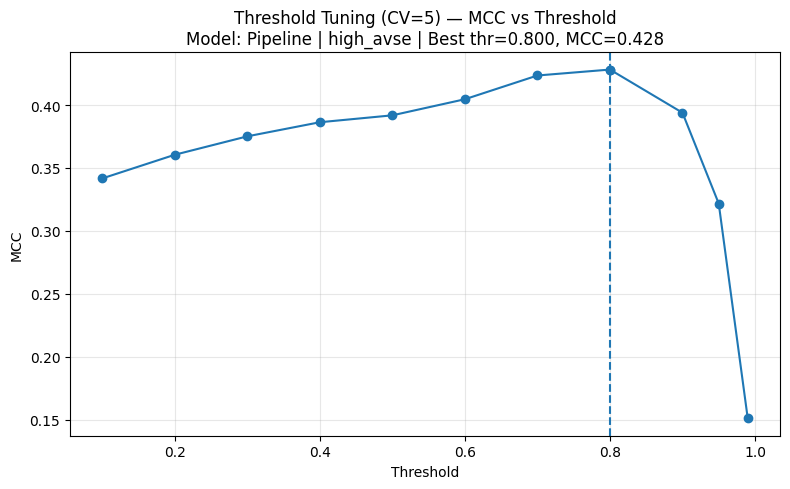

>>> Logistic Regression Threshold Tuning <<<


,Threshold,MCC,Precision,Recall,True_F1,False_F1,TN,FP,FN,TP,CV_AUC_PR,CV_AUC_ROC
0,0.80,0.428184,0.995531,0.994711,0.995121,0.432551,3835,4606,5456,1026103,0.999295,0.944348
1,0.70,0.423477,0.994822,0.997000,0.995910,0.422319,3088,5353,3095,1028464,0.999295,0.944348
2,0.60,0.404617,0.994317,0.997970,0.996140,0.390620,2557,5884,2094,1029465,0.999295,0.944348
3,0.90,0.393901,0.996700,0.986532,0.991590,0.370138,5072,3369,13893,1017666,0.999295,0.944348
4,0.50,0.391830,0.994001,0.998512,0.996252,0.364724,2225,6216,1535,1030024,0.999295,0.944348
5,0.40,0.386342,0.993801,0.998876,0.996332,0.346823,2014,6427,1159,1030400,0.999295,0.944348
6,0.30,0.375140,0.993619,0.999095,0.996349,0.325444,1822,6619,934,1030625,0.999295,0.944348
7,0.20,0.360512,0.993440,0.999256,0.996340,0.301420,1634,6807,767,1030792,0.999295,0.944348
8,0.10,0.341702,0.993243,0.999407,0.996315,0.272328,1427,7014,612,1030947,0.999295,0.944348
9,0.95,0.321748,0.997674,0.966932,0.982062,0.251330,6116,2325,34112,997447,0.999295,0.944348


In [51]:
df_lr_tuning = tune_thresholds(
    lr_best_model, 
    X_train, 
    y_train,
    base_dir=base_dir+"/logreg"
)

print(">>> Logistic Regression Threshold Tuning <<<")
display(df_lr_tuning)

In [49]:
best_row_lr = df_lr_tuning.loc[df_lr_tuning['MCC'].idxmax()]
best_threshold_lr = best_row_lr['Threshold']

print(f"Best Params: {lr_grid.best_params_}")
print(f"Best Threshold: {best_threshold_lr}")
print(f"Best MCC:       {best_row_lr['MCC']:.4f}")

Best Params: {'lr__C': 1, 'lr__class_weight': {0: 2, 1: 1}}
Best Threshold: 0.8
Best MCC:       0.4282



 FINAL EVALUATION: best_logreg (Threshold = 0.8)
              precision    recall  f1-score   support

       False     0.4133    0.4437    0.4280      3160
        True     0.9955    0.9949    0.9952    386840

    accuracy                         0.9904    390000
   macro avg     0.7044    0.7193    0.7116    390000
weighted avg     0.9907    0.9904    0.9906    390000

AUC-ROC Score: 0.942898
AUC-PR Score:  0.999292
MCC Score:     0.423391
Saved confusion matrix plot to: high_avse_plots/logreg/final_eval_cm_best_logreg_high_avse.png


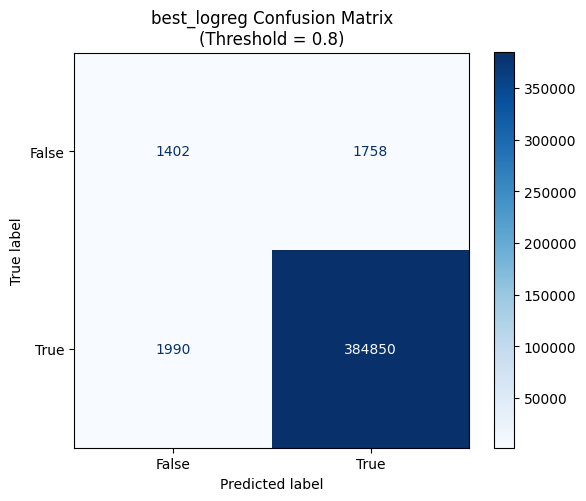

Saved ROC curve plot to: high_avse_plots/logreg/final_eval_roc_best_logreg_high_avse.png


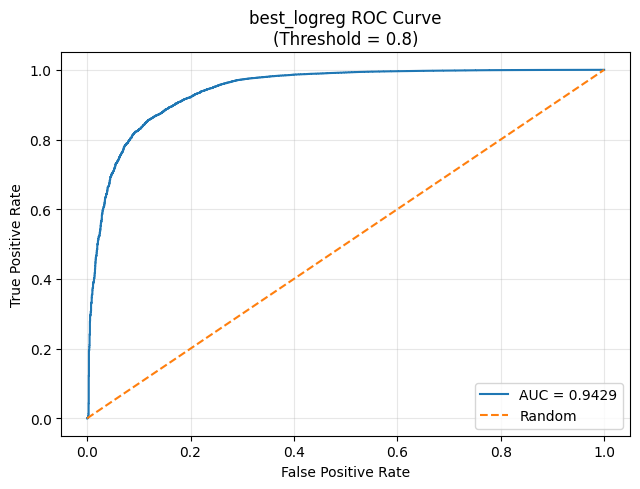

Saved PR curve plot to: high_avse_plots/logreg/final_eval_pr_best_logreg_high_avse.png


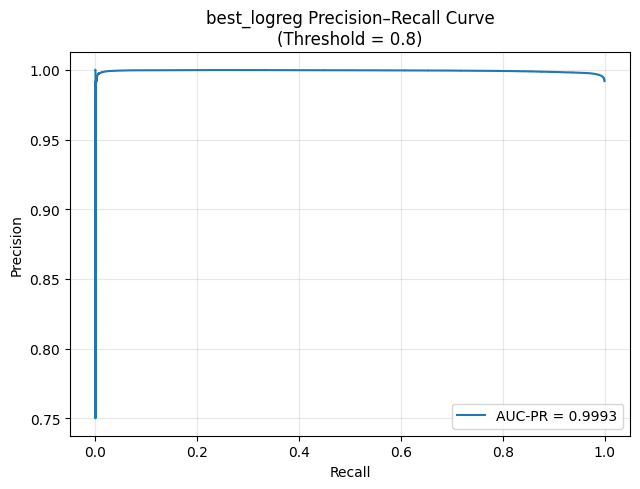

Saved/updated transposed metrics CSV to: high_avse_plots/final_eval_metrics_by_model_columns.csv


,metric,best_logreg_high_avse
0,threshold,0.800000
1,auc_roc,0.942898
2,auc_pr,0.999292
3,mcc,0.423391
4,tn,1402.000000
5,fp,1758.000000
6,fn,1990.000000
7,tp,384850.000000
8,precision_pos,0.995453
9,recall_pos,0.994856


In [56]:
evaluate_model_with_threshold(
    lr_best_model, 
    X_test, 
    y_test, 
    best_threshold_lr, 
    model_name="best_logreg",
    base_dir=base_dir+"/logreg"
)

In [57]:
save_lr_feature_importance(
    pipe_baseline,
    feature_cols=feature_cols,
    base_dir=base_dir+"/logreg",
    run_name="high_avse",
    model_name="best_logreg",
    save_csv=True,
)

Saved LR feature importance CSV to: high_avse_plots/logreg/feature_importance_lr_best_logreg_high_avse.csv


(                    Feature  Coefficient  Importance
 0          current_kurtosis     3.073010    3.073010
 1                      AvsE    -3.038263    3.038263
 2               total_power    -3.025100    3.025100
 3              time_to_peak    -2.309842    2.309842
 4          tail_slope_no_pz    -1.637403    1.637403
 5                  tdrift50     1.165955    1.165955
 6                      LQ80    -1.151986    1.151986
 7                       SCA     1.022350    1.022350
 8             GradWidthMain     1.016693    1.016693
 9                        ED    -0.699620    0.699620
 10                     HFER    -0.634220    0.634220
 11         current_skewness    -0.496610    0.496610
 12        time_to_main_peak     0.432534    0.432534
 13                      tfr    -0.394100    0.394100
 14                 tdrift99     0.360275    0.360275
 15                      PPR     0.281850    0.281850
 16                 tdrift10     0.270808    0.270808
 17                      tp0

### XGBoost

In [59]:
# ==========================================
# 1. SETUP & IMBALANCE HANDLING
# ==========================================
# Calculate Ratio: (Count of 0) / (Count of 1)
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)
print(f"Baseline Imbalance Ratio (Neg/Pos): {ratio:.5f}")

# The Parameter Grid (includes Defaults)
param_grid_xgb = {
    'scale_pos_weight': [1, ratio, ratio * 0.5, ratio * 2, 0.05, 0.1, 0.5], 
    'max_depth': [3, 4, 5, 6],            
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],   
    'n_estimators': [100, 200, 500, 1000],     
    'gamma': [0, 0.1, 1.0],                      
    'colsample_bytree': [0.7, 0.9, 1.0],
    'subsample': [0.6, 0.8, 1.0],
}

# The Classifier
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    n_jobs=-1,
    random_state=42,
    eval_metric='logloss'
)

Baseline Imbalance Ratio (Neg/Pos): 0.00818


In [60]:
# HYPERPARAMETER TUNING (The Search)
search_xgb = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_grid_xgb,
    n_iter=20,
    scoring=scoring_metrics,  
    refit='MCC',          
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    verbose=1,
    n_jobs=-1,
    random_state=42
)

print("Starting Hyperparameter Tuning...")
search_xgb.fit(X_train, y_train)

Starting Hyperparameter Tuning...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","XGBClassifier...ree=None, ...)"
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'colsample_bytree': [0.7, 0.9, ...], 'gamma': [0, 0.1, ...], 'learning_rate': [0.01, 0.05, ...], 'max_depth': [3, 4, ...], ...}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",20
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.","{'AUC_PR': make_scorer(a...redict_proba'), 'AUC_ROC': make_scorer(r...redict_proba'), 'Class0_F1': make_scorer(f..., pos_label=0), 'Class1_F1': make_scorer(f..., pos_label=1), ...}"
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",'MCC'
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitter

In [61]:
# Get the winner
best_xgb = search_xgb.best_estimator_

# 1. Convert the raw results dictionary to a DataFrame
results = pd.DataFrame(search_xgb.cv_results_)

# 3. Sort, Filter, and Store in a new DataFrame variable
top_models_df = results.sort_values(by='mean_test_MCC', ascending=False)[cols_to_show]

# 4. Display the stored DataFrame
top_models_df

,params,mean_test_MCC,mean_test_AUC_PR,mean_test_AUC_ROC,mean_test_Class0_F1,mean_test_Class1_F1,mean_test_TN,mean_test_FP,mean_test_TP,mean_test_FN
3,"{'subsample': 1.0, 'scale_pos_weight': 0.5, 'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.3, 'gamma': 0.1, 'colsample_bytree': 1.0}",0.681776,0.999961,0.995653,0.683651,0.997513,1109.4,578.8,205864.0,447.8
15,"{'subsample': 1.0, 'scale_pos_weight': 1, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 1.0}",0.629996,0.999831,0.989273,0.628490,0.997273,952.6,735.6,205921.4,390.4
13,"{'subsample': 1.0, 'scale_pos_weight': 0.1, 'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 1.0, 'colsample_bytree': 1.0}",0.623726,0.999952,0.994565,0.598859,0.995301,1442.0,246.2,204626.0,1685.8
11,"{'subsample': 0.8, 'scale_pos_weight': 0.1, 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 1.0, 'colsample_bytree': 0.7}",0.623462,0.999952,0.994591,0.596900,0.995219,1455.2,233.0,204579.4,1732.4
1,"{'subsample': 1.0, 'scale_pos_weight': 0.5, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.7}",0.618348,0.999930,0.992110,0.621114,0.996981,1021.6,666.6,205732.4,579.4
14,"{'subsample': 1.0, 'scale_pos_weight': 1, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.3, 'gamma': 0, 'colsample_bytree': 1.0}",0.605236,0.999310,0.958243,0.605533,0.997047,936.2,752.0,205844.4,467.4
16,"{'subsample': 1.0, 'scale_pos_weight': 1, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 1.0}",0.568241,0.999685,0.985727,0.558562,0.997013,781.0,907.2,205984.8,327.0
5,"{'subsample': 0.6, 'scale_pos_weight': 0.1, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 1.0}",0.547606,0.999811,0.981099,0.532584,0.994787,1221.8,466.4,204633.4,1678.4
7,"{'subsample': 0.8, 'scale_pos_weight': 1, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.9}",0.546654,0.999911,0.989986,0.535274,0.996903,737.2,951.0,205983.0,328.8
8,"{'subsample': 0.8, 'scale_pos_weight': 0.004091380134340353, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 0.9}",0.543811,0.999964,0.995760,0.472749,0.991147,1623.8,64.4,202754.0,3557.8


Generating Cross-Validated Probabilities (CV=5)...
Saved threshold tuning progress CSV to: high_avse_plots/xgb/threshold_tuning_progress_XGBClassifier_high_avse_cv5.csv
Saved threshold MCC plot to: high_avse_plots/xgb/threshold_tuning_mcc_XGBClassifier_high_avse_cv5.png


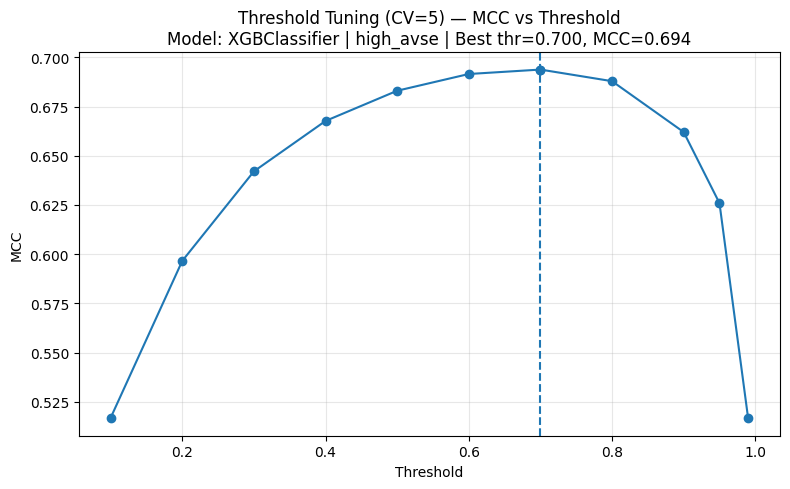

>>> XGBoost Threshold Tuning <<<


,Threshold,MCC,Precision,Recall,True_F1,False_F1,TN,FP,FN,TP,CV_AUC_PR,CV_AUC_ROC
0,0.70,0.693790,0.998052,0.996435,0.997243,0.693651,6435,2006,3678,1027881,0.999962,0.995678
1,0.60,0.691536,0.997661,0.997180,0.997420,0.693826,6029,2412,2909,1028650,0.999962,0.995678
2,0.80,0.687893,0.998481,0.995280,0.996878,0.681460,6879,1562,4869,1026690,0.999962,0.995678
3,0.50,0.683033,0.997231,0.997795,0.997513,0.685073,5583,2858,2275,1029284,0.999962,0.995678
4,0.40,0.667692,0.996767,0.998290,0.997528,0.666536,5101,3340,1764,1029795,0.999962,0.995678
5,0.90,0.662041,0.998967,0.993020,0.995985,0.641272,7382,1059,7200,1024359,0.999962,0.995678
6,0.30,0.642084,0.996179,0.998779,0.997477,0.632699,4489,3952,1260,1030299,0.999962,0.995678
7,0.95,0.625943,0.999302,0.990201,0.994731,0.588195,7728,713,10108,1021451,0.999962,0.995678
8,0.20,0.596610,0.995418,0.999208,0.997309,0.570635,3696,4745,817,1030742,0.999962,0.995678
9,0.10,0.516877,0.994382,0.999618,0.996993,0.456769,2615,5826,394,1031165,0.999962,0.995678


In [62]:
df_xgb_tuning = tune_thresholds(
    best_xgb, 
    X_train, 
    y_train,
    base_dir=base_dir+"/xgb"
)

print(">>> XGBoost Threshold Tuning <<<")
display(df_xgb_tuning)

In [63]:
best_row_xgb = df_xgb_tuning.loc[df_xgb_tuning['MCC'].idxmax()]
best_threshold_xgb = best_row_xgb['Threshold']

print(f"Best Params: {search_xgb.best_params_}")
print(f"Best Threshold: {best_threshold_xgb}")
print(f"Best MCC:       {best_row_xgb['MCC']:.4f}")

Best Params: {'subsample': 1.0, 'scale_pos_weight': 0.5, 'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.3, 'gamma': 0.1, 'colsample_bytree': 1.0}
Best Threshold: 0.7
Best MCC:       0.6938



 FINAL EVALUATION: xgboost (Threshold = 0.7)
              precision    recall  f1-score   support

       False     0.6268    0.7734    0.6924      3160
        True     0.9981    0.9962    0.9972    386840

    accuracy                         0.9944    390000
   macro avg     0.8125    0.8848    0.8448    390000
weighted avg     0.9951    0.9944    0.9947    390000

AUC-ROC Score: 0.996345
AUC-PR Score:  0.999969
MCC Score:     0.693552
Saved confusion matrix plot to: high_avse_plots/xgb/final_eval_cm_xgboost_high_avse.png


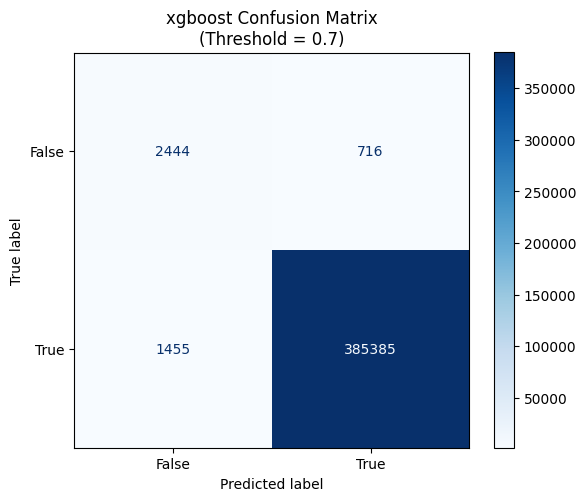

Saved ROC curve plot to: high_avse_plots/xgb/final_eval_roc_xgboost_high_avse.png


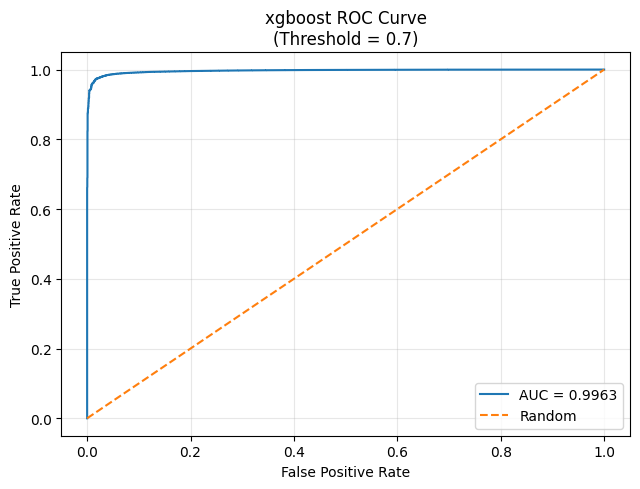

Saved PR curve plot to: high_avse_plots/xgb/final_eval_pr_xgboost_high_avse.png


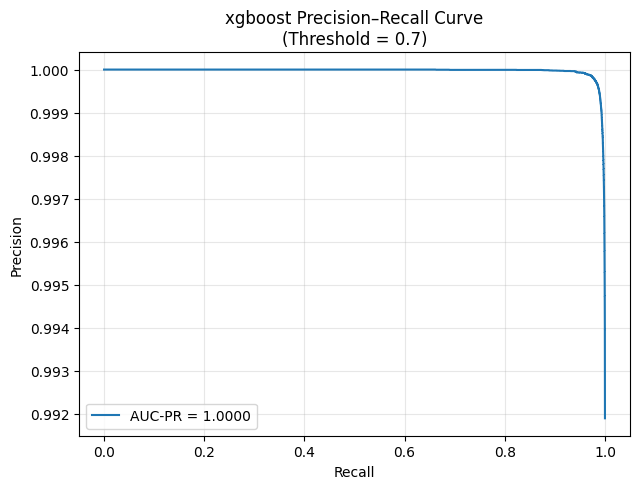

Saved/updated transposed metrics CSV to: high_avse_plots/final_eval_metrics_by_model_columns.csv


,metric,xgboost_high_avse
0,threshold,0.700000
1,auc_roc,0.996345
2,auc_pr,0.999969
3,mcc,0.693552
4,tn,2444.000000
5,fp,716.000000
6,fn,1455.000000
7,tp,385385.000000
8,precision_pos,0.998146
9,recall_pos,0.996239


In [64]:
evaluate_model_with_threshold(
    best_xgb, 
    X_test, 
    y_test, 
    best_threshold_xgb, 
    model_name="xgboost",
    base_dir=base_dir+"/xgb"
)

SHAP shape: (390000, 27)


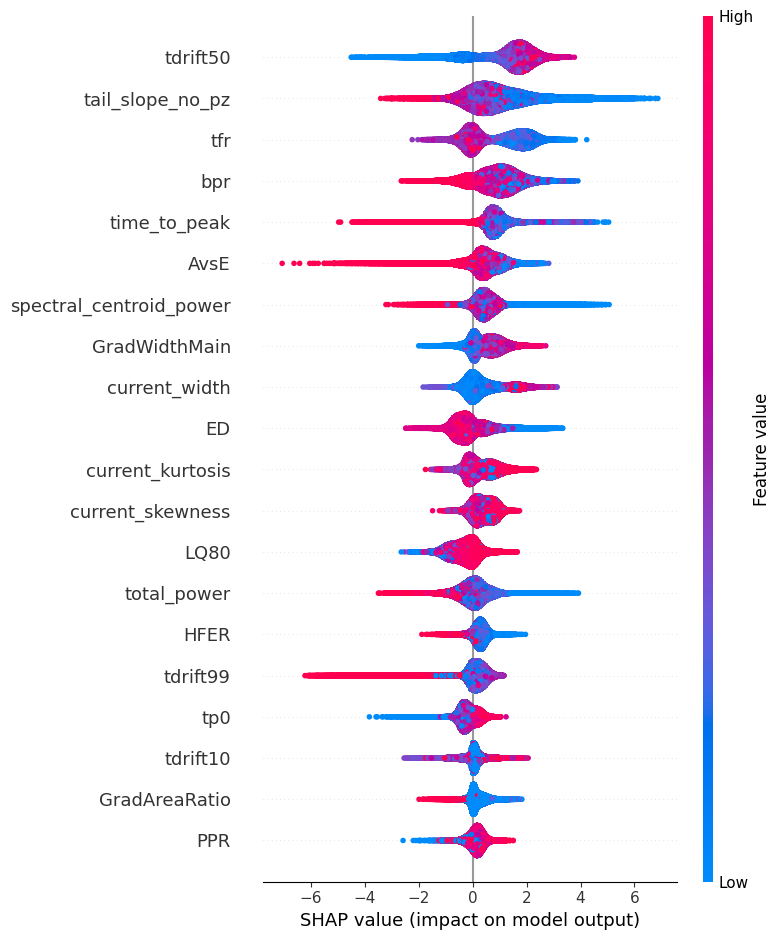

Saved: high_avse_plots/xgb/shap_summary_xgboost_high_avse.png


In [22]:
shap_summary_plot_save(
    best_xgb, 
    X_test, 
    base_dir="high_avse_plots/xgb",
    model_name="xgboost",
)

### Random Forest

In [15]:
# ==========================================
# 1. SETUP & GRID
# ==========================================
# Random Forest Grid
param_grid_rf = {
    'n_estimators': [100, 200],        
    'max_depth': [5, 10, 15, None],          
    'min_samples_leaf': [1, 2, 4],           
    'min_samples_split': [2, 5, 10],         
    'max_features': ['sqrt', 'log2'],
    'class_weight': [
        None,                    # Baseline: treat them as they appear
        'balanced_subsample',
        'balanced',             # Standard: helps catch the minority (but increases FPs)
        {0:1, 1:2},          # Strong majority bias (significant FP reduction
        {0:1, 1:5},            # Mild imbalance
        {0:2, 1:1}           # Slight minority bias (if 'balanced' is too much)
    ]
}

rf_clf = RandomForestClassifier(
    random_state=42, 
    n_jobs=1
)

# ==========================================
# 2. HYPERPARAMETER TUNING
# ==========================================
search_rf = RandomizedSearchCV(
    estimator=rf_clf,
    param_distributions=param_grid_rf,
    n_iter=15,
    scoring=scoring_metrics,  
    refit='MCC',          
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    verbose=1,
    n_jobs=4,
    random_state=42
)

print("Starting Hyperparameter Tuning for Random Forest...")
search_rf.fit(X_train, y_train)

Starting Hyperparameter Tuning for Random Forest...
Fitting 3 folds for each of 15 candidates, totalling 45 fits


/opt/conda/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",RandomForestC...ndom_state=42)
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'class_weight': [None, 'balanced_subsample', ...], 'max_depth': [5, 10, ...], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': [1, 2, ...], ...}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",15
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.","{'AUC_PR': make_scorer(a...redict_proba'), 'AUC_ROC': make_scorer(r...redict_proba'), 'Class0_F1': make_scorer(f..., pos_label=0), 'Class1_F1': make_scorer(f..., pos_label=1), ...}"
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",4
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",'MCC'
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is u

In [16]:
best_rf = search_rf.best_estimator_

results_rf = pd.DataFrame(search_rf.cv_results_)

rf_models_results = results_rf.sort_values(by='mean_test_MCC', ascending=False)[cols_to_show]
rf_models_results

,params,mean_test_MCC,mean_test_AUC_PR,mean_test_AUC_ROC,mean_test_Class0_F1,mean_test_Class1_F1,mean_test_TN,mean_test_FP,mean_test_TP,mean_test_FN
11,"{'n_estimators': 100, 'min_samples_split': 10,...",0.565695,0.999833,0.982082,0.557891,0.996969,1317.000000,1496.666667,343262.333333,590.666667
10,"{'n_estimators': 200, 'min_samples_split': 5, ...",0.537059,0.999935,0.992394,0.486272,0.992409,2454.666667,359.000000,339025.666667,4827.333333
1,"{'n_estimators': 100, 'min_samples_split': 2, ...",0.479586,0.999617,0.962646,0.468115,0.996508,1059.000000,1754.666667,343202.000000,651.000000
8,"{'n_estimators': 200, 'min_samples_split': 10,...",0.459479,0.999806,0.979434,0.390453,0.996756,716.666667,2097.000000,343712.666667,140.333333
14,"{'n_estimators': 100, 'min_samples_split': 10,...",0.447215,0.999894,0.988343,0.365987,0.996725,652.000000,2161.666667,343756.000000,97.000000
0,"{'n_estimators': 100, 'min_samples_split': 2, ...",0.420428,0.999901,0.988828,0.326714,0.984167,2600.666667,213.000000,333341.000000,10512.000000
4,"{'n_estimators': 200, 'min_samples_split': 10,...",0.376849,0.999528,0.955114,0.312804,0.996418,562.333333,2251.333333,343633.666667,219.333333
9,"{'n_estimators': 200, 'min_samples_split': 2, ...",0.353173,0.999794,0.978312,0.244521,0.996428,399.000000,2414.666667,343802.666667,50.333333
12,"{'n_estimators': 200, 'min_samples_split': 2, ...",0.345897,0.999784,0.976947,0.239580,0.996404,391.000000,2422.666667,343794.333333,58.666667
2,"{'n_estimators': 200, 'min_samples_split': 10,...",0.337004,0.999783,0.976908,0.226173,0.996383,365.000000,2448.666667,343805.333333,47.666667


Generating Cross-Validated Probabilities (CV=5)...
Saved threshold tuning progress CSV to: high_avse_plots/rf/threshold_tuning_progress_RandomForestClassifier_high_avse_cv5.csv
Saved threshold MCC plot to: high_avse_plots/rf/threshold_tuning_mcc_RandomForestClassifier_high_avse_cv5.png


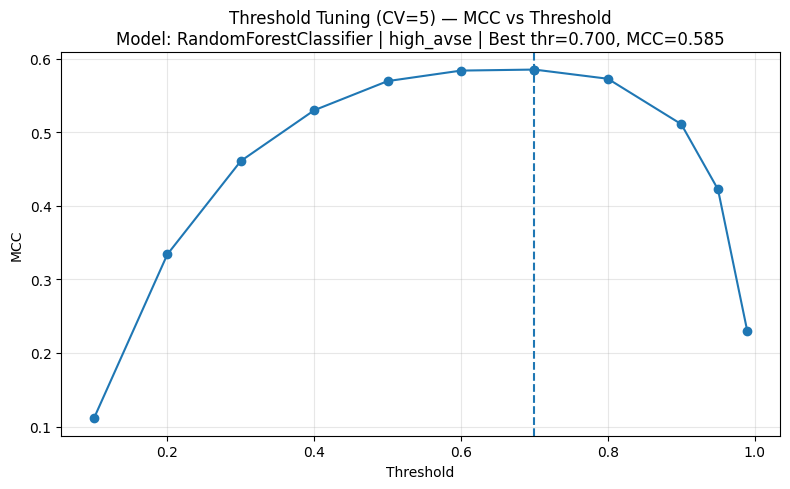

>>> Random Forest Threshold Tuning <<<


,Threshold,MCC,Precision,Recall,True_F1,False_F1,TN,FP,FN,TP,CV_AUC_PR,CV_AUC_ROC
0,0.70,0.585065,0.996961,0.995802,0.996382,0.587357,5310,3131,4330,1027229,0.999828,0.981593
1,0.60,0.583677,0.996357,0.997233,0.996795,0.585915,4680,3761,2854,1028705,0.999828,0.981593
2,0.80,0.572581,0.997619,0.993402,0.995506,0.564448,5995,2446,6806,1024753,0.999828,0.981593
3,0.50,0.569393,0.995684,0.998307,0.996994,0.561565,3977,4464,1746,1029813,0.999828,0.981593
4,0.40,0.529781,0.994905,0.999009,0.996953,0.501148,3164,5277,1022,1030537,0.999828,0.981593
5,0.90,0.510907,0.998455,0.986354,0.992368,0.467381,6867,1574,14077,1017482,0.999828,0.981593
6,0.30,0.460797,0.994002,0.999512,0.996749,0.397563,2219,6222,503,1031056,0.999828,0.981593
7,0.95,0.422358,0.998953,0.973256,0.985937,0.340366,7389,1052,27588,1003971,0.999828,0.981593
8,0.20,0.333996,0.992900,0.999874,0.996375,0.221231,1066,7375,130,1031429,0.999828,0.981593
9,0.99,0.229423,0.999596,0.883713,0.938089,0.118311,8073,368,119957,911602,0.999828,0.981593


In [17]:
df_rf_tuning = tune_thresholds(
    best_rf, 
    X_train, 
    y_train,
    base_dir=base_dir+"/rf"
)

print(">>> Random Forest Threshold Tuning <<<")
display(df_rf_tuning)

In [18]:
best_row_rf = df_rf_tuning.loc[df_rf_tuning['MCC'].idxmax()]
best_threshold_rf = best_row_rf['Threshold']

print(f"Best Params: {search_rf.best_params_}")
print(f"Best Threshold: {best_threshold_rf}")
print(f"Best MCC: {best_row_rf['MCC']:.4f}")

Best Params: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 10, 'class_weight': {0: 2, 1: 1}}
Best Threshold: 0.7
Best MCC: 0.5851



 FINAL EVALUATION: rf (Threshold = 0.7)
              precision    recall  f1-score   support

       False     0.5394    0.6193    0.5766      3160
        True     0.9969    0.9957    0.9963    386840

    accuracy                         0.9926    390000
   macro avg     0.7682    0.8075    0.7864    390000
weighted avg     0.9932    0.9926    0.9929    390000

AUC-ROC Score: 0.981332
AUC-PR Score:  0.999821
MCC Score:     0.574297
Saved confusion matrix plot to: high_avse_plots/rf/final_eval_cm_rf_high_avse.png


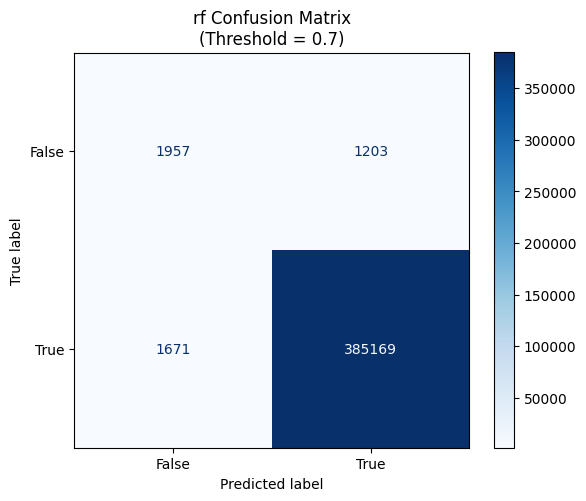

Saved ROC curve plot to: high_avse_plots/rf/final_eval_roc_rf_high_avse.png


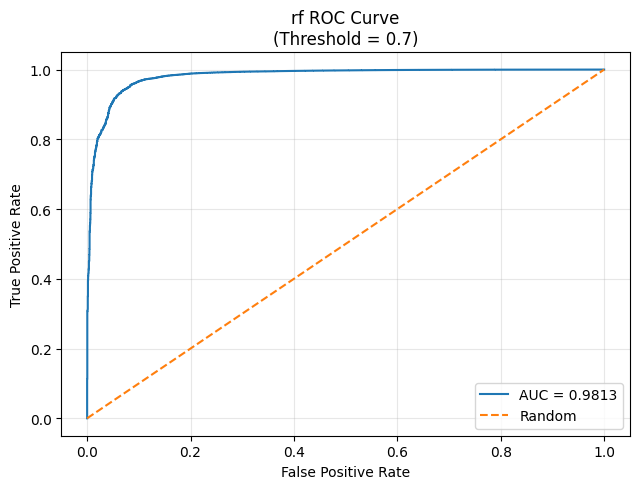

Saved PR curve plot to: high_avse_plots/rf/final_eval_pr_rf_high_avse.png


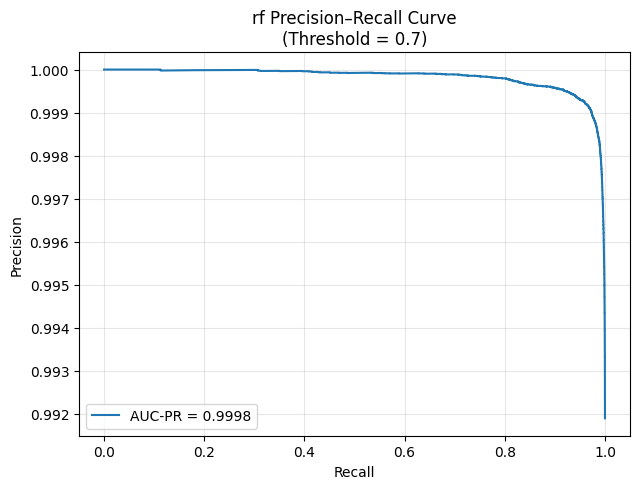

Saved/updated transposed metrics CSV to: high_avse_plots/final_eval_metrics_by_model_columns.csv


,metric,rf_high_avse
0,threshold,0.700000
1,auc_roc,0.981332
2,auc_pr,0.999821
3,mcc,0.574297
4,tn,1957.000000
5,fp,1203.000000
6,fn,1671.000000
7,tp,385169.000000
8,precision_pos,0.996886
9,recall_pos,0.995680


In [24]:
evaluate_model_with_threshold(
    best_rf, 
    X_test, 
    y_test, 
    best_threshold_rf, 
    model_name="rf",
    base_dir=base_dir+"/rf"
)

In [ ]:
shap_summary_plot_save(
    best_rf, 
    X_test, 
    base_dir=base_dir+"/rf",
    model_name="rf",
)

### Balanced Random Forest

In [14]:
# ==========================================
# 2. SETUP MODEL & GRID
# ==========================================
# Balanced Random Forest automatically undersamples majority class per tree
brf_model = BalancedRandomForestClassifier(
    n_jobs=1,
    random_state=42,
    replacement=True,         # Crucial for undersampling
    sampling_strategy="all"   # 1:1 ratio in every tree
)

param_grid_brf = {
    'n_estimators': [500, 1000],          # High tree count
    'max_depth': [10, 20, None],          # Depth control
    'min_samples_leaf': [1, 2, 4],        # Overfitting control
    'max_features': ['sqrt', 'log2'],
    'class_weight': [None]                # BRF handles balancing internally
}

# ==========================================
# 3. HYPERPARAMETER TUNING
# ==========================================
search_brf = RandomizedSearchCV(
    estimator=brf_model,
    param_distributions=param_grid_brf,
    n_iter=15,
    scoring=scoring_metrics,  # <--- Your custom list
    refit='MCC',              # <--- Optimize for MCC
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    verbose=1,
    n_jobs=4,
    random_state=42
)

print("Starting Balanced Random Forest Tuning...")
search_brf.fit(X_train, y_train)

Starting Balanced Random Forest Tuning...
Fitting 3 folds for each of 15 candidates, totalling 45 fits


/opt/conda/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",BalancedRando...ndom_state=42)
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'class_weight': [None], 'max_depth': [10, 20, ...], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': [1, 2, ...], ...}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",15
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.","{'AUC_PR': make_scorer(a...redict_proba'), 'AUC_ROC': make_scorer(r...redict_proba'), 'Class0_F1': make_scorer(f..., pos_label=0), 'Class1_F1': make_scorer(f..., pos_label=1), ...}"
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",4
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",'MCC'
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are i

In [15]:
# 1. Convert the raw results dictionary to a DataFrame
results = pd.DataFrame(search_brf.cv_results_)

# 3. Sort, Filter, and Store in a new DataFrame variable
#    We sort by MCC because that was your refit metric
top_models_df = results.sort_values(by='mean_test_MCC', ascending=False)[cols_to_show]

# Display the top 5
top_models_df

,params,mean_test_MCC,mean_test_AUC_PR,mean_test_AUC_ROC,mean_test_Class0_F1,mean_test_Class1_F1,mean_test_TN,mean_test_FP,mean_test_TP,mean_test_FN
1,"{'n_estimators': 1000, 'min_samples_leaf': 1, ...",0.423018,0.999938,0.992849,0.321648,0.983139,2703.666667,110.000000,332556.000000,11297.000000
7,"{'n_estimators': 500, 'min_samples_leaf': 1, '...",0.422809,0.999937,0.992808,0.321394,0.983120,2703.666667,110.000000,332543.333333,11309.666667
5,"{'n_estimators': 1000, 'min_samples_leaf': 1, ...",0.421675,0.999936,0.992741,0.320049,0.983015,2703.333333,110.333333,332474.333333,11378.666667
3,"{'n_estimators': 500, 'min_samples_leaf': 1, '...",0.421280,0.999936,0.992694,0.319622,0.982987,2702.666667,111.000000,332456.000000,11397.000000
2,"{'n_estimators': 500, 'min_samples_leaf': 2, '...",0.416768,0.999935,0.992602,0.314229,0.982554,2702.000000,111.666667,332168.666667,11684.333333
6,"{'n_estimators': 1000, 'min_samples_leaf': 2, ...",0.414320,0.999935,0.992464,0.311311,0.982312,2701.666667,112.000000,332008.333333,11844.666667
4,"{'n_estimators': 500, 'min_samples_leaf': 4, '...",0.403328,0.999933,0.992183,0.297688,0.981070,2708.000000,105.666667,331178.333333,12674.666667
9,"{'n_estimators': 1000, 'min_samples_leaf': 4, ...",0.403015,0.999933,0.992192,0.297444,0.981058,2706.333333,107.333333,331172.333333,12680.666667
14,"{'n_estimators': 1000, 'min_samples_leaf': 4, ...",0.402843,0.999933,0.992191,0.297315,0.981054,2705.333333,108.333333,331170.333333,12682.666667
11,"{'n_estimators': 500, 'min_samples_leaf': 4, '...",0.400577,0.999929,0.991906,0.294474,0.980775,2707.333333,106.333333,330983.666667,12869.333333


In [ ]:
best_brf = search_brf.best_estimator_

df_brf_tuning = tune_thresholds(
    best_brf, 
    X_train, 
    y_train,
    base_dir=base_dir+"/brf"
)

print(">>> Balanced Random Forest Threshold Tuning <<<")
display(df_brf_tuning)

Generating Cross-Validated Probabilities (CV=5)...


In [ ]:
best_row_brf = df_brf_tuning.loc[df_brf_tuning['MCC'].idxmax()]
best_threshold_brf = best_row_brf['Threshold']

print(f"Best Params: {search_brf.best_params_}")
print(f"Best Threshold: {best_threshold_brf}")
print(f"Best MCC: {best_row_brf['MCC']:.4f}")

In [ ]:
evaluate_model_with_threshold(
    best_brf, 
    X_test, 
    y_test, 
    best_threshold_brf, 
    model_name="brf",
    base_dir=base_dir+"/brf"
)

In [ ]:
shap_summary_plot_save(
    best_brf, 
    X_test, 
    base_dir=base_dir+"/brf",
    model_name="brf",
)

## Final Best Model for high_avse

XGBoost

Best Params: {'subsample': 1.0, 'scale_pos_weight': 0.5, 'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.3, 'gamma': 0.1, 'colsample_bytree': 1.0}
Best Threshold: 0.7
Best MCC:       0.6938

In [11]:
best_threshold_xgb = 0.7

In [12]:
# XGBoost model using your tuned parameters
best_xgb = xgb.XGBClassifier(
    subsample=1.0,
    scale_pos_weight=0.5,
    n_estimators=500,
    max_depth=6,
    learning_rate=0.3,
    gamma=0.1,
    colsample_bytree=1.0,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1,
)

In [13]:
# fit
best_xgb.fit(X_train, y_train)

,objective,'binary:logistic'
,use_label_encoder,None
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,1.0
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [15]:
y_probs_final = best_xgb.predict_proba(X_test)[:, 1]
y_pred_final = (y_probs_final >= best_threshold_xgb).astype(int)

df_preds = pd.DataFrame({
    "id": test_ids,
    "high_avse_preds": y_pred_final,   # <-- thresholded predictions
})

preds_path = os.path.join("high_avse_plots", f"high_avse_test_preds.csv")
df_preds.to_csv(preds_path, index=False)
print(f"Saved predictions CSV to: {preds_path}")

Saved predictions CSV to: high_avse_plots/high_avse_test_preds.csv


In [18]:
(y_pred_final == y_test).mean()

0.9950717948717949